In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [61]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [62]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["dropoff_month"] = train["dropoff_datetime"].dt.month

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday

train["pickup_hour"] = train["pickup_datetime"].dt.hour
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour

In [63]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri

train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)
# train["working_day"] = 1 * (train.pickup_weekday.values == "True")

In [64]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [65]:
pickup_lat = tuple(train["pickup_latitude"])
pickup_lng = tuple(train["pickup_longitude"])
dropoff_lat = tuple(train["dropoff_latitude"])
dropoff_lng = tuple(train["dropoff_longitude"])

pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

In [66]:
distance = []
for i in range(len(pickup_loc)):
    distance.append(haversine(pickup_loc[i], dropoff_loc[i]))
    
print(len(pickup_loc), len(dropoff_loc), len(distance))
train["distance"] = distance

1458644 1458644 1458644


In [67]:
# 종속변수/독립변수 분리

columns_X = [elem for elem in train.columns if elem != "trip_duration"]
train_X0 = train[columns_X]
train_y = train[["trip_duration"]]

In [68]:
real = ["passenger_count", "distance", "pickup_longitude", 
        "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
cats = [elem for elem in train.columns if elem not in real]
# ["pickup_hour", "pickup_weekday", "pickup_month", "dropoff_hour", "dropoff_weekday", "dropoff_month", ]
for elem in ["pickup_datetime", "dropoff_datetime"]:
    cats.remove(elem)

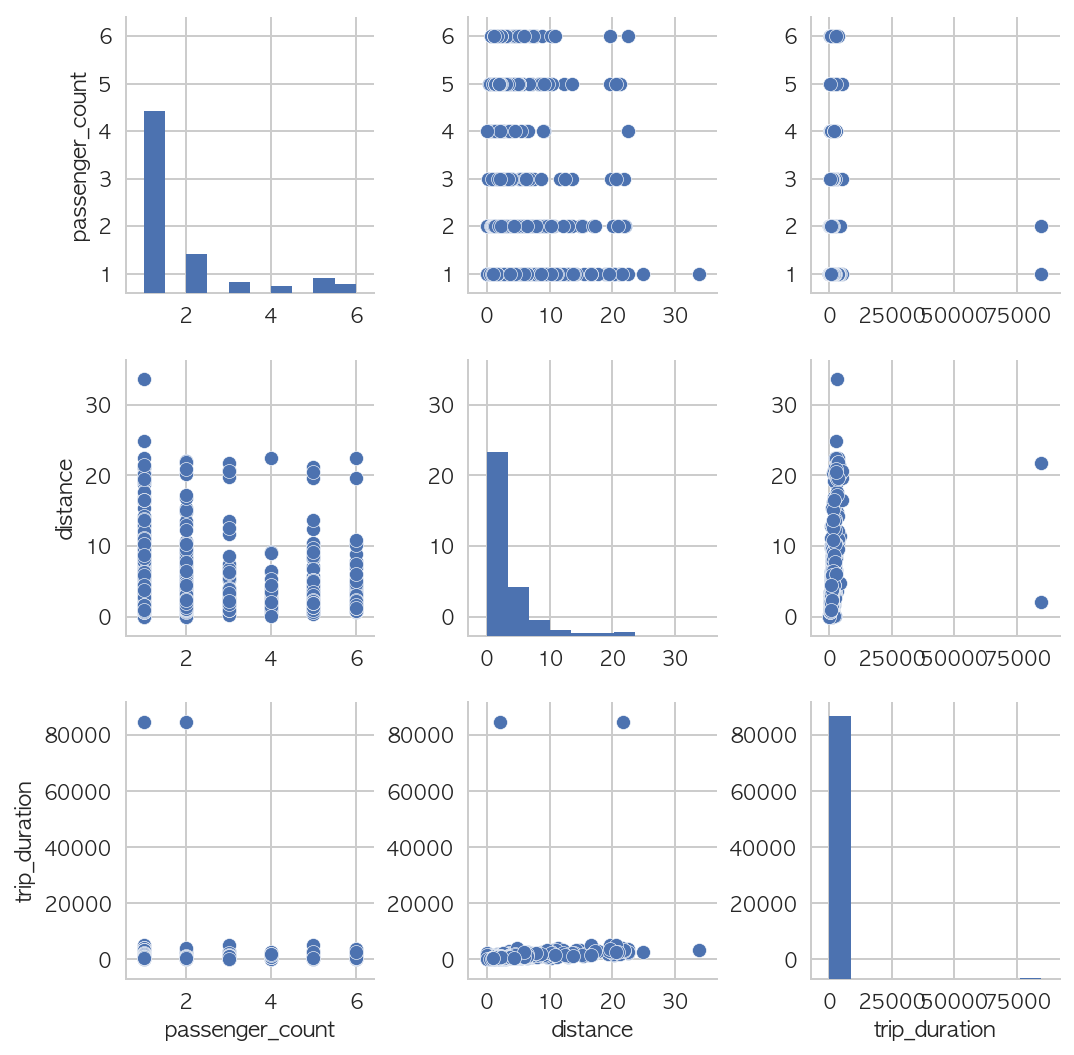

In [69]:
# passenger_count, distance, avg_speed_h

sns.pairplot(pd.concat([train_X0[real[:2]], train_y], axis=1)[::1000])
plt.show()

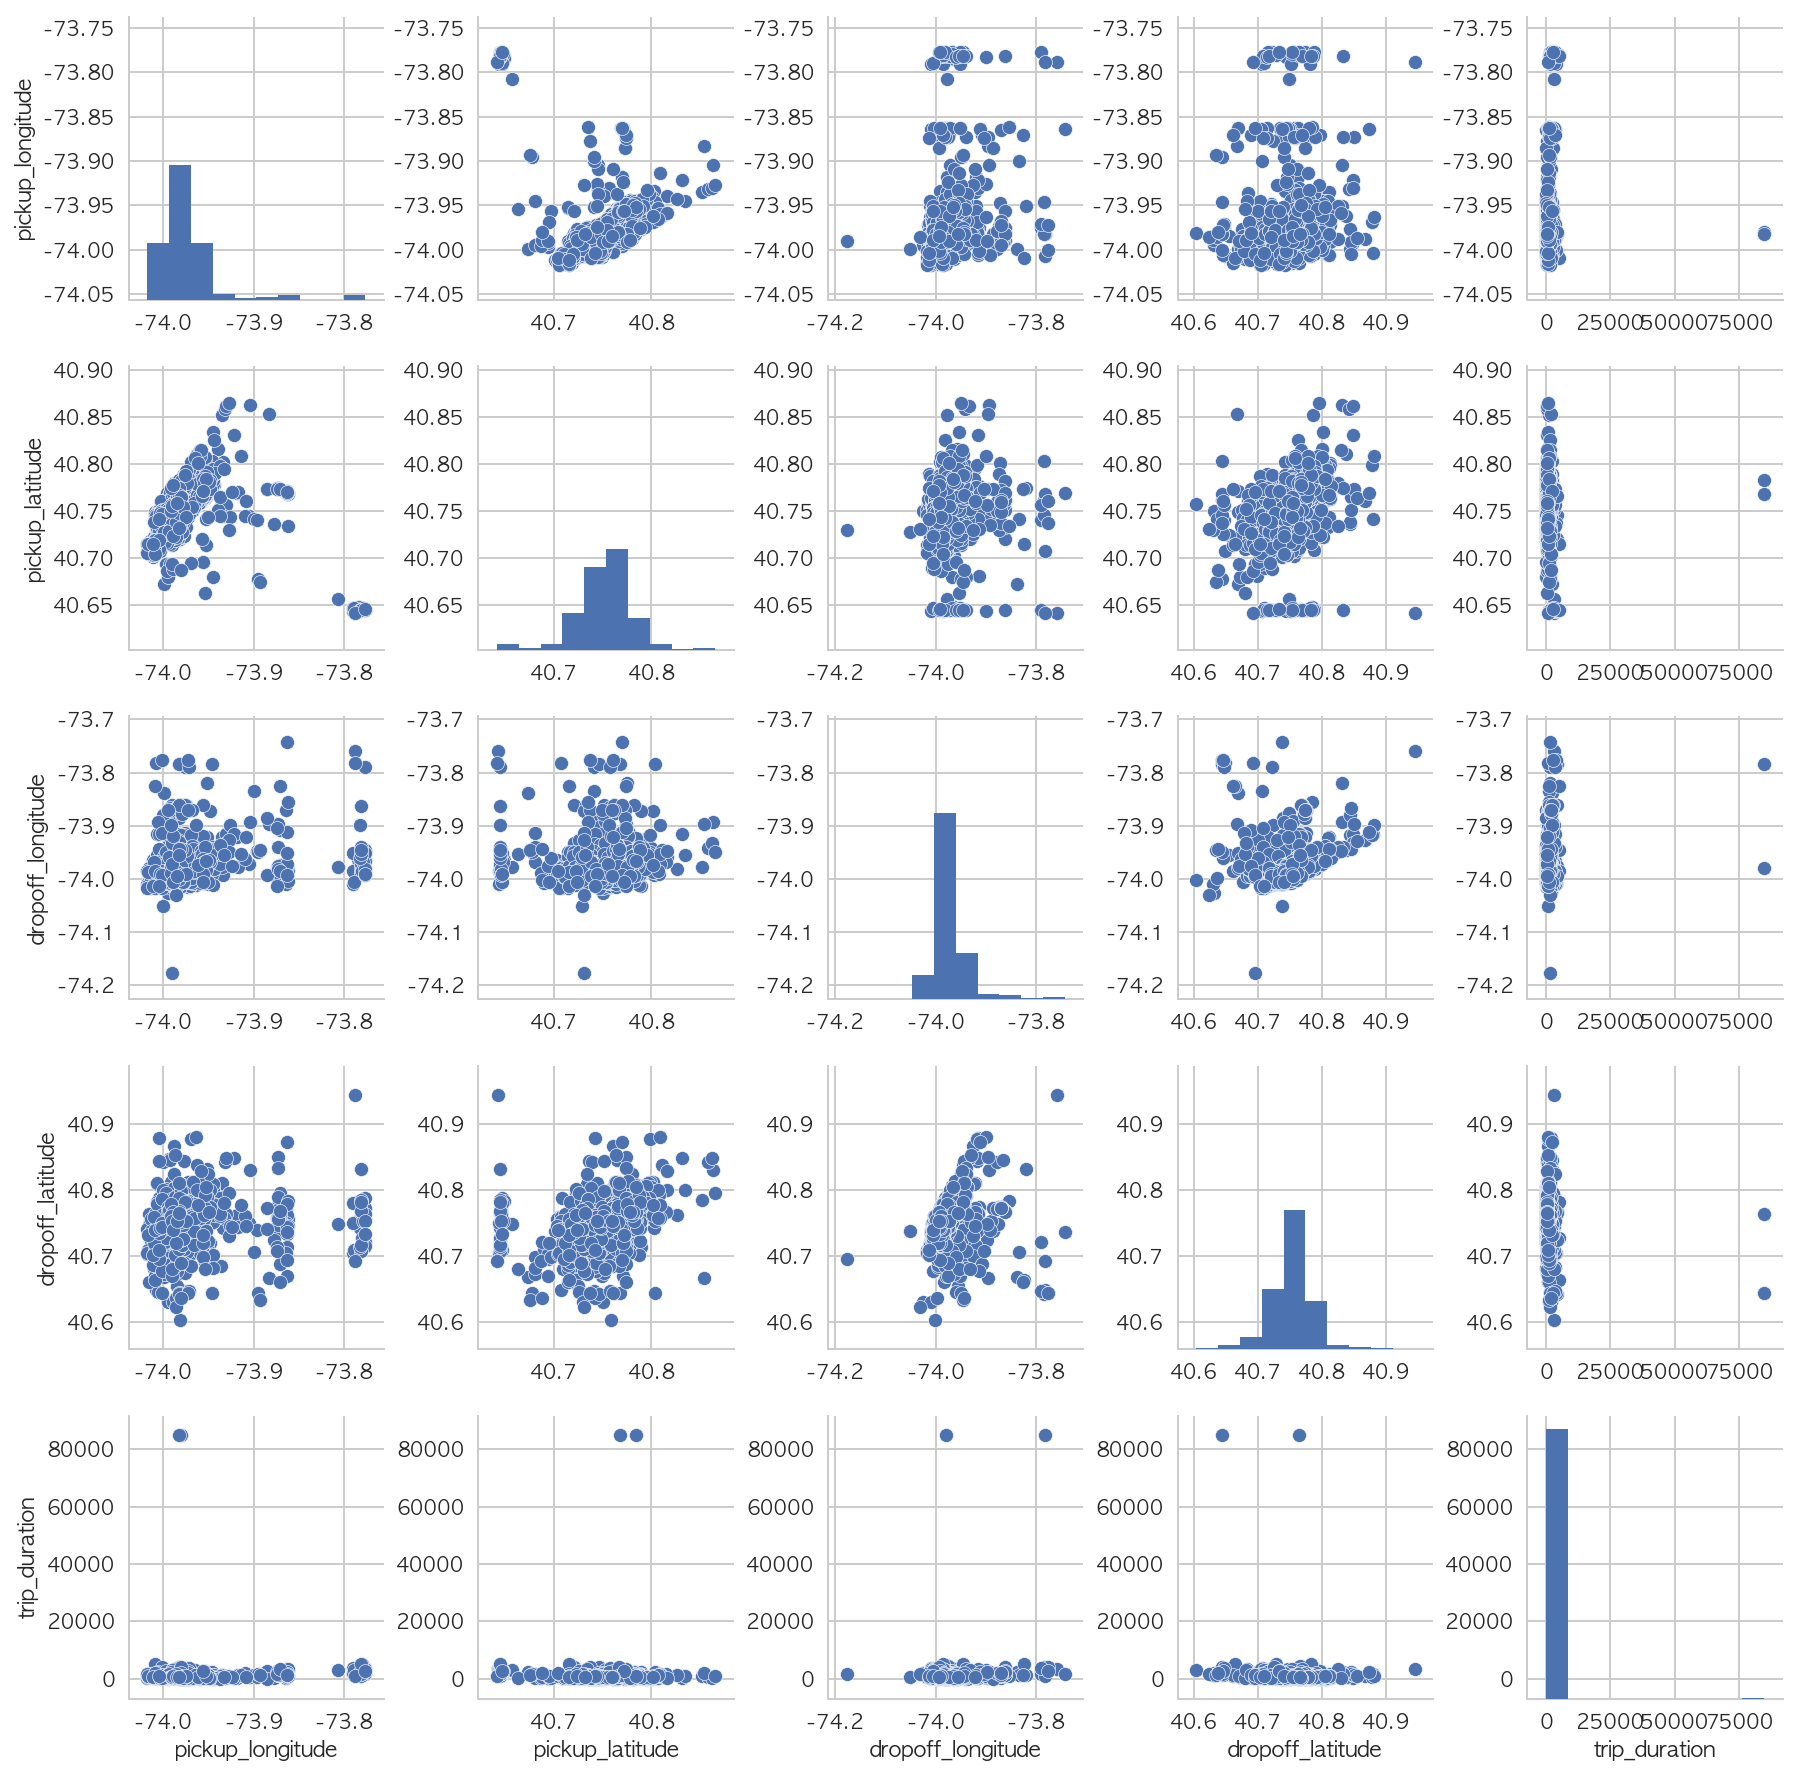

In [70]:
# "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"

sns.pairplot(pd.concat([train_X0[real[2:]], train_y], axis=1)[::1000])
plt.show()

In [71]:
def ttest_ind_cats(var):
    tmp_list = train[var].unique()
    print(sp.stats.ttest_ind(train["trip_duration"][train[var] == tmp_list[0]], 
                             train["trip_duration"][train[var] == tmp_list[1]]))

In [72]:
# 각 카테고리의 클래스별 평균이 같은지 t-test (클래스를 0, 1 두 개 가지는 카테고리에 대해)
# 유의 수준 0.01

bin_cats = ["vendor_id", "store_and_fwd_flag", "working_day"]

for _, elem in enumerate(bin_cats):
    print("[ {} ]".format(elem))
    ttest_ind_cats(elem)
    print("-" * 80)    

[ vendor_id ]
Ttest_indResult(statistic=24.527274857356531, pvalue=8.046167819039434e-133)
--------------------------------------------------------------------------------
[ store_and_fwd_flag ]
Ttest_indResult(statistic=-2.0825876188794363, pvalue=0.037289002528894187)
--------------------------------------------------------------------------------
[ working_day ]
Ttest_indResult(statistic=4.8414640555035238, pvalue=1.288991482784057e-06)
--------------------------------------------------------------------------------


In [84]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p((distance))"
                            "+ pickup_hour + 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.938
Model:                                 OLS   Adj. R-squared:                  0.938
Method:                      Least Squares   F-statistic:                 1.036e+07
Date:                     Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:31:22   Log-Likelihood:            -2.5812e+06
No. Observations:                  1364925   AIC:                         5.162e+06
Df Residuals:                      1364923   BIC:                         5.162e+06
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [74]:
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
np.log1p((distance)),519819.043070,1.0,1.878315e+06,0.0
abs(np.sin(pickup_hour)),589.686993,1.0,2.130776e+03,0.0
Residual,403675.221054,1458641.0,NaN,NaN


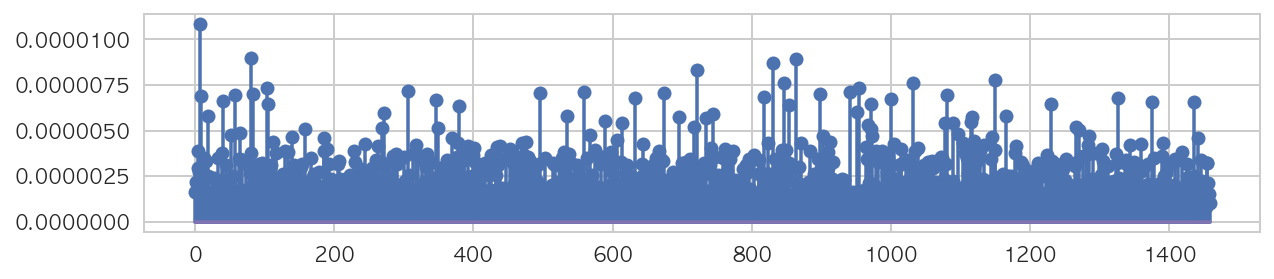

In [75]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::1000])
plt.show()

In [76]:
idx = np.where(hat > 2 * hat.mean())[0]
len(idx)

93719

In [77]:
train.drop(idx, inplace=True)
train.reset_index_index(drop=True, inplace=True)

In [78]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p((distance))"
                            "+ abs(np.sin(pickup_hour))", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.517
Model:                                 OLS   Adj. R-squared:                  0.517
Method:                      Least Squares   F-statistic:                 7.303e+05
Date:                     Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:18:16   Log-Likelihood:            -1.0194e+06
No. Observations:                  1364925   AIC:                         2.039e+06
Df Residuals:                      1364922   BIC:                         2.039e+06
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

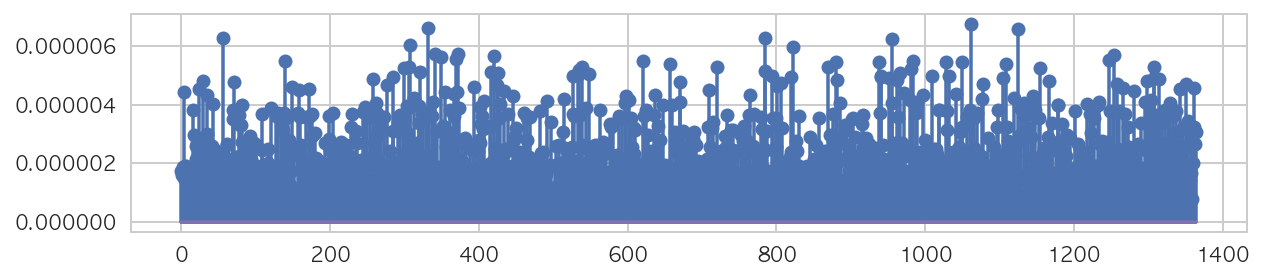

In [79]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::1000])
plt.show()

In [27]:
idx = np.where(hat > 2* hat.mean())[0]
len(idx)

96401

In [28]:
train.drop(idx, inplace=True)

ValueError: labels [     67     115    1297 ..., 1398157 1399589 1399632] not contained in axis

In [33]:
idx[1399589]

IndexError: index 1399589 is out of bounds for axis 0 with size 96401

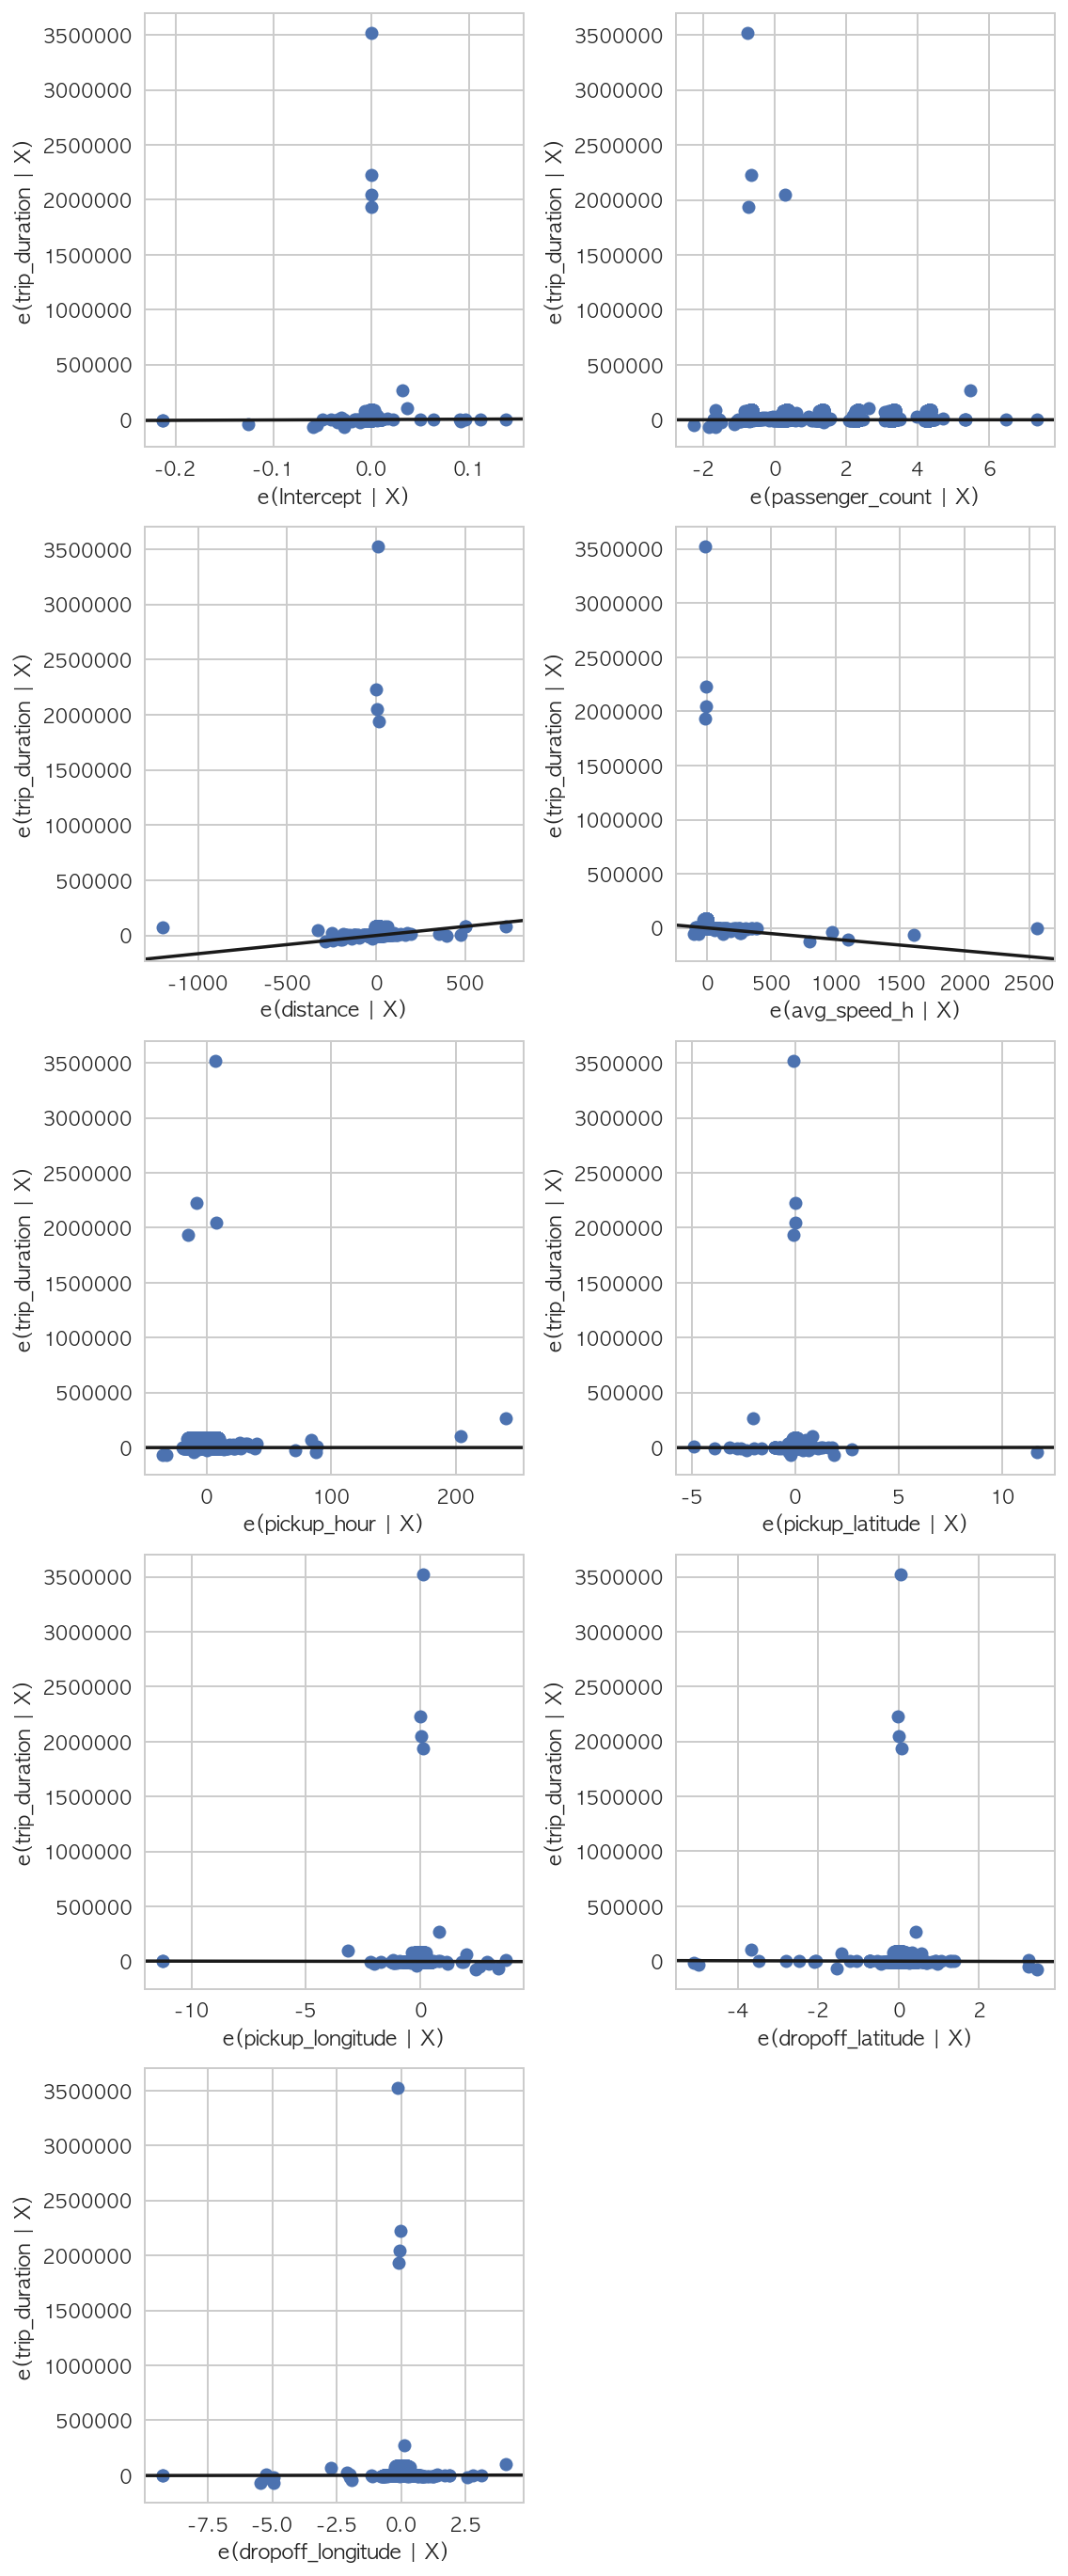

In [50]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

### 아웃라이어 제거 1. trip_duration < 1500000

In [20]:
train_outlier01 = train[train["trip_duration"] < 150000]

In [46]:
model_outlier01 = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                                      pickup_hour + pickup_latitude + pickup_longitude +\
                                      dropoff_latitude + dropoff_longitude + C(vendor_id)", train_outlier01)
result_outlier01 = model_outlier01.fit()
print(result_outlier01.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     6495.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:26:46   Log-Likelihood:            -1.3776e+07
No. Observations:             1456182   AIC:                         2.755e+07
Df Residuals:                 1456172   BIC:                         2.755e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.141e+04   5304.66

In [22]:
sm.stats.anova_lm(result_outlier01, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,2.211112e+09,1.0,228.322546,1.396648e-51
distance,4.645340e+11,1.0,47968.436958,0.000000e+00
avg_speed_h,1.981595e+11,1.0,20462.225604,0.000000e+00
pickup_hour,1.143625e+08,1.0,11.809231,5.893941e-04
pickup_latitude,2.427121e+08,1.0,25.062798,5.549965e-07
pickup_longitude,8.398741e+08,1.0,86.726584,1.247749e-20
dropoff_latitude,1.701064e+09,1.0,175.654249,4.331712e-40
dropoff_longitude,8.361522e+08,1.0,86.342256,1.515380e-20
Residual,1.412561e+13,1458631.0,NaN,NaN


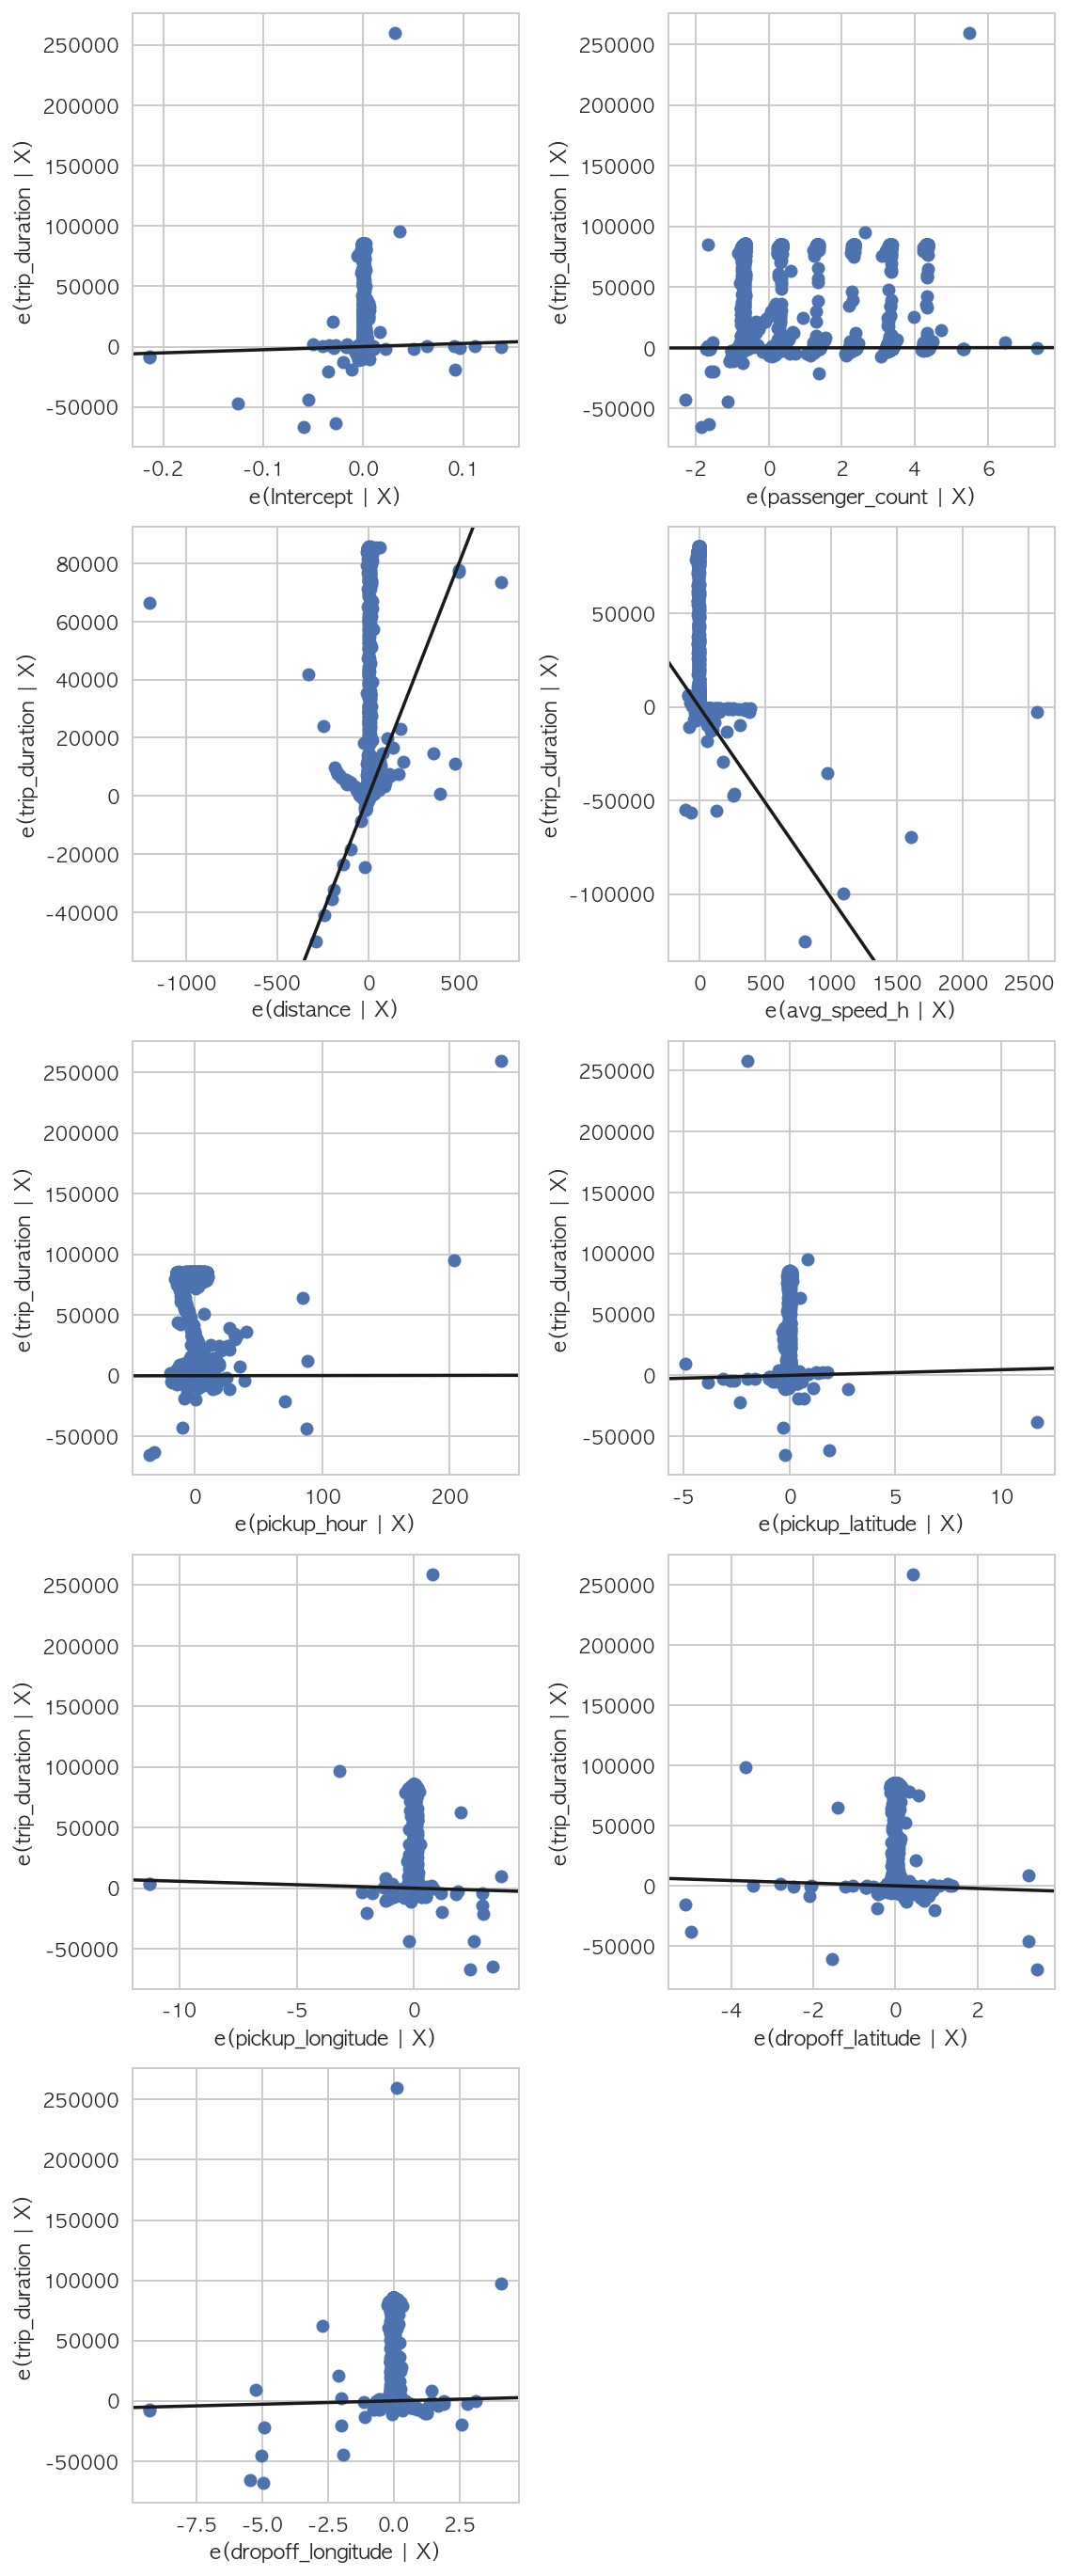

In [23]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result_outlier01, fig=fig)
fig.suptitle("")
plt.show()

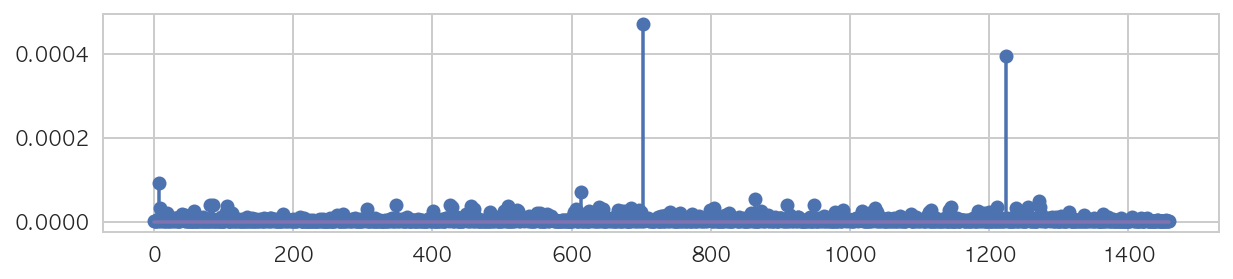

In [25]:
influence = result_outlier01.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::1000])
plt.show()

### 아웃라이어 제거 2. 레버리지 0.0002 이상 제거

In [26]:
idx = np.where(hat > 0.0002)[0]
idx[:10]

array([   991,   1107,  14502,  73414,  81841,  85764, 100295, 107171,
       108729, 112247])

In [27]:
train_outlier01.drop(idx, inplace=True)

In [28]:
model_outlier01 = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                                      pickup_hour + pickup_latitude + pickup_longitude +\
                                      dropoff_latitude + dropoff_longitude", train_outlier01)
result_outlier01 = model_outlier01.fit()
print(result_outlier01.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     7103.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:48:48   Log-Likelihood:            -1.3799e+07
No. Observations:             1458442   AIC:                         2.760e+07
Df Residuals:                 1458433   BIC:                         2.760e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.062e+04   5309.36

In [29]:
sm.stats.anova_lm(result_outlier01, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,2.198786e+09,1.0,227.126888,2.545721e-51
distance,4.621274e+11,1.0,47736.148251,0.000000e+00
avg_speed_h,1.825092e+11,1.0,18852.564330,0.000000e+00
pickup_hour,1.260661e+08,1.0,13.022186,3.078326e-04
pickup_latitude,9.817885e+08,1.0,101.415326,7.471868e-24
pickup_longitude,9.507500e+08,1.0,98.209154,3.770813e-23
dropoff_latitude,2.499617e+09,1.0,258.201696,4.280649e-58
dropoff_longitude,7.854284e+08,1.0,81.132010,2.113765e-19
Residual,1.411890e+13,1458433.0,NaN,NaN


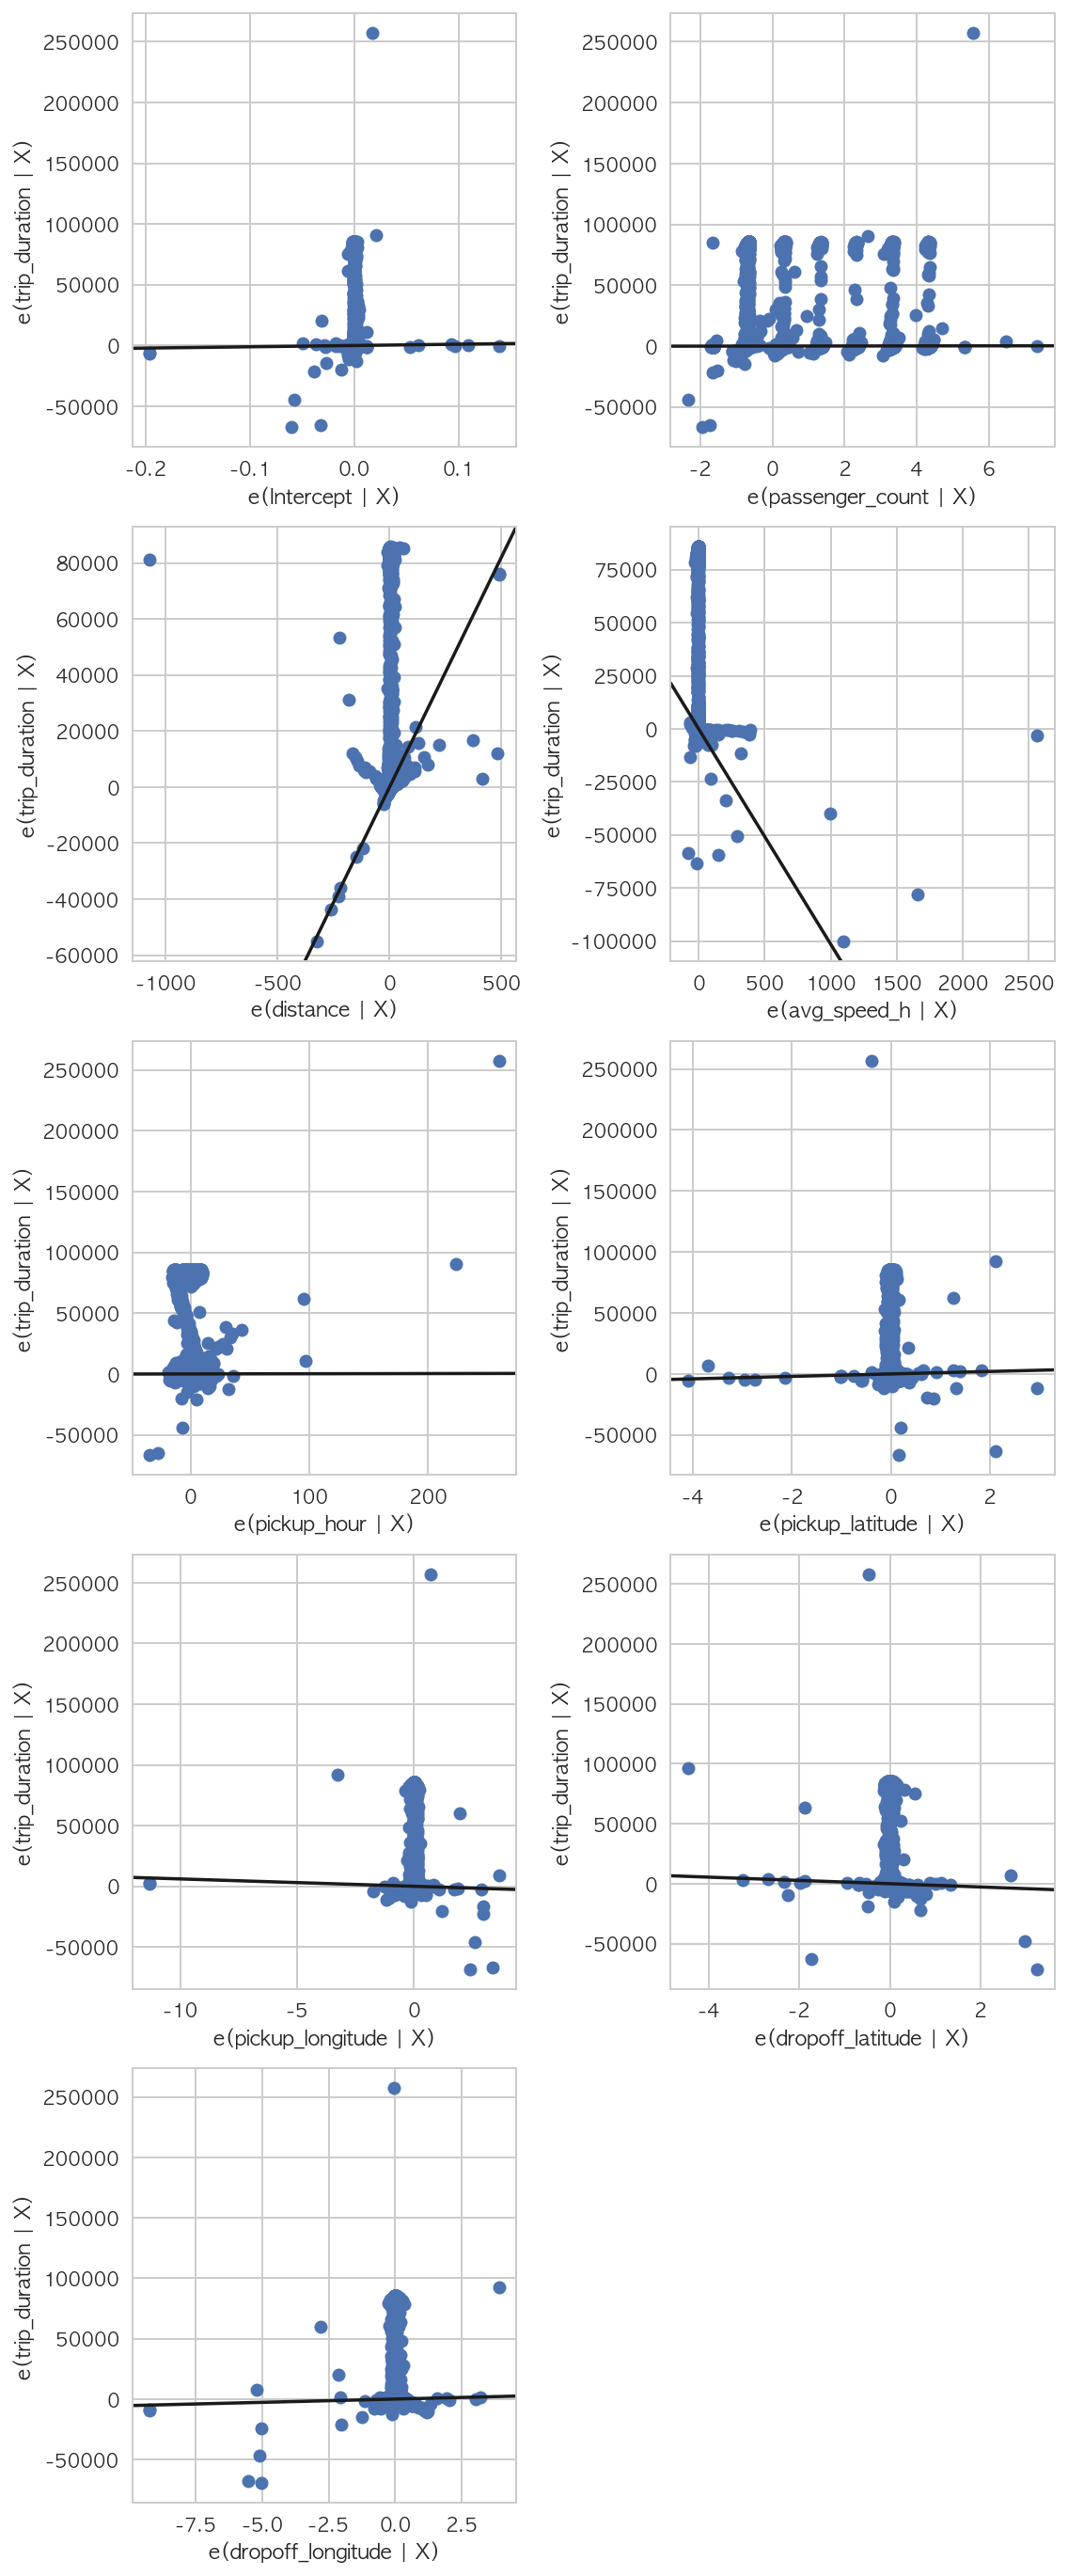

In [78]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result_outlier01, fig=fig)
fig.suptitle("")
plt.show()

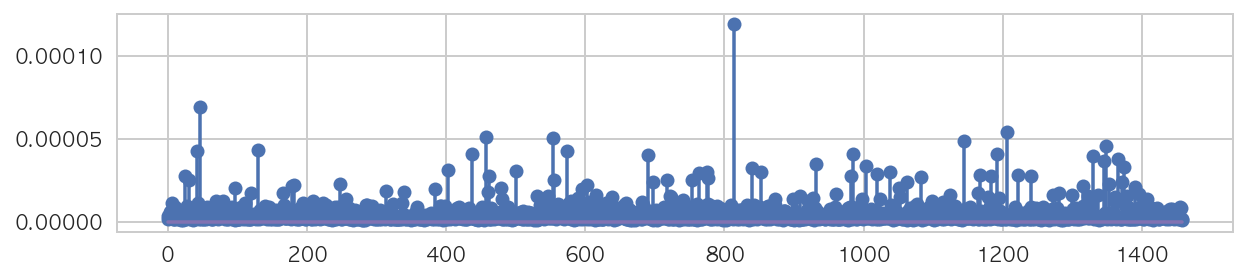

In [30]:
influence = result_outlier01.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::1000])
plt.show()

In [34]:
idx = np.where(hat > 0.00005)[0]

train_outlier01.drop(idx, inplace=True)

ValueError: labels [ 125657  831312 1175740 1213620] not contained in axis

In [32]:
model_outlier01 = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                                      pickup_hour + pickup_latitude + pickup_longitude +\
                                      dropoff_latitude + dropoff_longitude", train_outlier01)
result_outlier01 = model_outlier01.fit()
print(result_outlier01.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     7103.
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:49:07   Log-Likelihood:            -1.3777e+07
No. Observations:             1456182   AIC:                         2.755e+07
Df Residuals:                 1456173   BIC:                         2.755e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.075e+04   5307.48

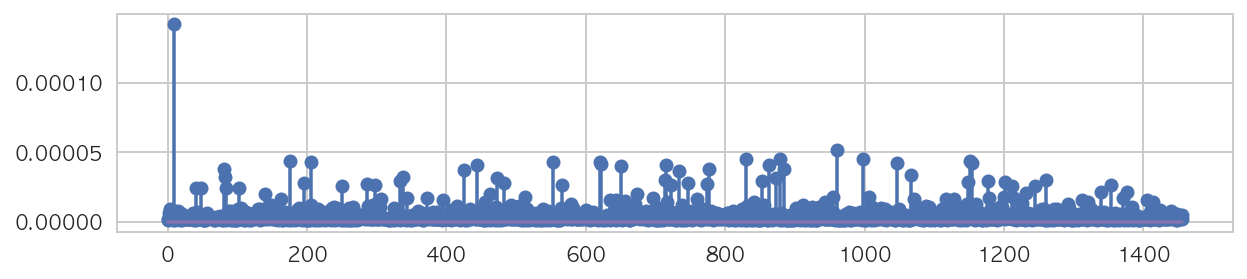

In [33]:
influence = result_outlier01.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat[::1000])
plt.show()

In [38]:
idx = np.where(hat > 0.00005)[0]

train_outlier01.drop(idx, inplace=True)

ValueError: labels [ 125657  831312 1175740 1213620] not contained in axis

In [138]:
ax = plt.subplot()
plt.scatter(train_X0, y)
sm.graphics.abline_plot(model_results=result_outlier01, ax=ax)

# idx = hat > 0.05
# plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
# plt.show()

ValueError: too many values to unpack (expected 2)

In [30]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ passenger_count + distance + avg_speed_h + pickup_hour +\
                            C(working_day) + 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.448
Model:                                 OLS   Adj. R-squared:                  0.448
Method:                      Least Squares   F-statistic:                 2.365e+05
Date:                     Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                             12:30:12   Log-Likelihood:            -1.3034e+06
No. Observations:                  1458644   AIC:                         2.607e+06
Df Residuals:                      1458638   BIC:                         2.607e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

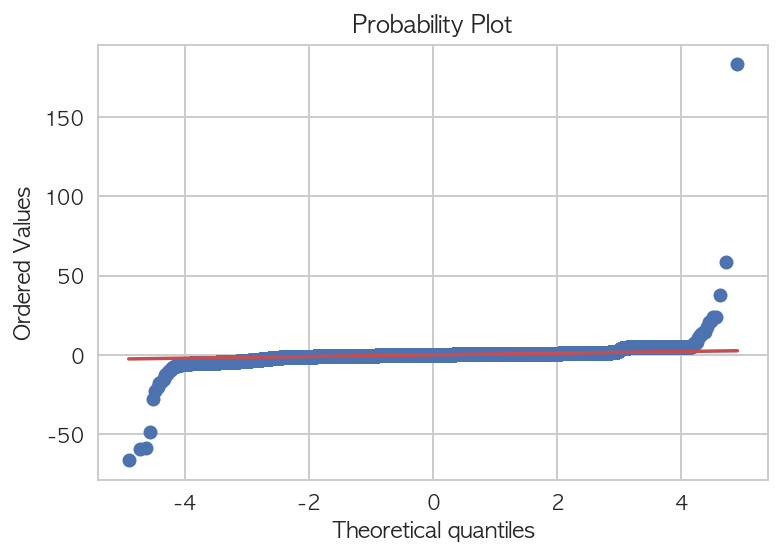

In [31]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

### 20. 실수값 (위/경도 추가) + 카테고리값 (working_day + pickup_weekday + pickup_hour)

In [40]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ distance + avg_speed_h + pickup_latitude + pickup_longitude +\
                            dropoff_latitude + dropoff_longitude + C(working_day + pickup_weekday + pickup_hour) + 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.457
Model:                                 OLS   Adj. R-squared:                  0.457
Method:                      Least Squares   F-statistic:                 3.614e+04
Date:                     Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                             12:35:45   Log-Likelihood:            -1.2908e+06
No. Observations:                  1458644   AIC:                         2.582e+06
Df Residuals:                      1458609   BIC:                         2.582e+06
Df Model:                               34                                         
Covariance Type:                 nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

### 21. 실수값 (위/경도 추가) + 카테고리값 (working_day + pickup_weekday + pickup_hour + vendor_id)

In [48]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ distance + avg_speed_h +\
                            pickup_latitude + pickup_longitude + dropoff_latitude + dropoff_longitude +\
                            C(working_day) + C(pickup_weekday) + C(pickup_hour) + C(vendor_id) + 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.465
Model:                                 OLS   Adj. R-squared:                  0.465
Method:                      Least Squares   F-statistic:                 3.522e+04
Date:                     Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                             17:49:13   Log-Likelihood:            -1.2803e+06
No. Observations:                  1458644   AIC:                         2.561e+06
Df Residuals:                      1458607   BIC:                         2.561e+06
Df Model:                               36                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [52]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ distance + C(working_day)+ 0", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.333
Model:                                 OLS   Adj. R-squared:                  0.333
Method:                      Least Squares   F-statistic:                 3.634e+05
Date:                     Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                             17:52:05   Log-Likelihood:            -1.4416e+06
No. Observations:                  1458644   AIC:                         2.883e+06
Df Residuals:                      1458641   BIC:                         2.883e+06
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [56]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ C(working_day)", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(working_day),1.0,2644.232156,2644.232156,4187.749349,0.0
Residual,1458642.0,921016.937527,0.631421,NaN,NaN


In [57]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ C(pickup_hour)", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_hour),23.0,9537.995238,414.695445,661.708495,0.0
Residual,1458620.0,914123.174445,0.626704,NaN,NaN


In [58]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ pickup_hour", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
pickup_hour,1.0,1414.068880,1414.068880,2236.515851,0.0
Residual,1458642.0,922247.100803,0.632264,NaN,NaN


In [69]:
model_tmp = sm.OLS.from_formula("np.log1p(trip_duration) ~ passenger_count + pickup_longitude +\
                                pickup_latitude + dropoff_longitude + dropoff_latitude + distance +\
                                avg_speed_h + pickup_hour", data=train)
result_tmp = model_tmp.fit()
sm.stats.anova_lm(result_tmp, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,141.916172,1.0,4.100411e+02,3.696199e-91
pickup_longitude,4373.879775,1.0,1.263753e+04,0.000000e+00
pickup_latitude,611.314407,1.0,1.766282e+03,0.000000e+00
dropoff_longitude,2106.356479,1.0,6.085936e+03,0.000000e+00
dropoff_latitude,1426.880381,1.0,4.122713e+03,0.000000e+00
distance,379607.279386,1.0,1.096807e+06,0.000000e+00
avg_speed_h,107700.088217,1.0,3.111799e+05,0.000000e+00
pickup_hour,1059.968983,1.0,3.062589e+03,0.000000e+00
Residual,504836.951953,1458635.0,NaN,NaN


In [70]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ C(vendor_id)", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(vendor_id),1.0,359.173770,359.173770,567.426419,2.153704e-125
Residual,1458642.0,923301.995914,0.632987,NaN,NaN


In [71]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ C(store_and_fwd_flag)", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(store_and_fwd_flag),1.0,216.953174,216.953174,342.692071,1.688042e-76
Residual,1458642.0,923444.216510,0.633085,NaN,NaN


In [72]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ C(pickup_weekday)", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_weekday),6.0,4025.115851,670.852642,1064.04102,0.0
Residual,1458637.0,919636.053832,0.630476,NaN,NaN


In [82]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ passenger_count + np.log1p(distance) + np.log1p(avg_speed_h)", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.869
Model:                                 OLS   Adj. R-squared:                  0.869
Method:                      Least Squares   F-statistic:                 3.233e+06
Date:                     Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                             20:00:48   Log-Likelihood:            -2.5252e+05
No. Observations:                  1458644   AIC:                         5.050e+05
Df Residuals:                      1458640   BIC:                         5.051e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### log(trip_duration) ~ log(distance), log(avg_speed_h)

In [85]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) + np.log1p(avg_speed_h) +\
                            pickup_latitude + pickup_longitude", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.872
Model:                                 OLS   Adj. R-squared:                  0.872
Method:                      Least Squares   F-statistic:                 2.481e+06
Date:                     Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                             20:01:30   Log-Likelihood:            -2.3811e+05
No. Observations:                  1458644   AIC:                         4.762e+05
Df Residuals:                      1458639   BIC:                         4.763e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

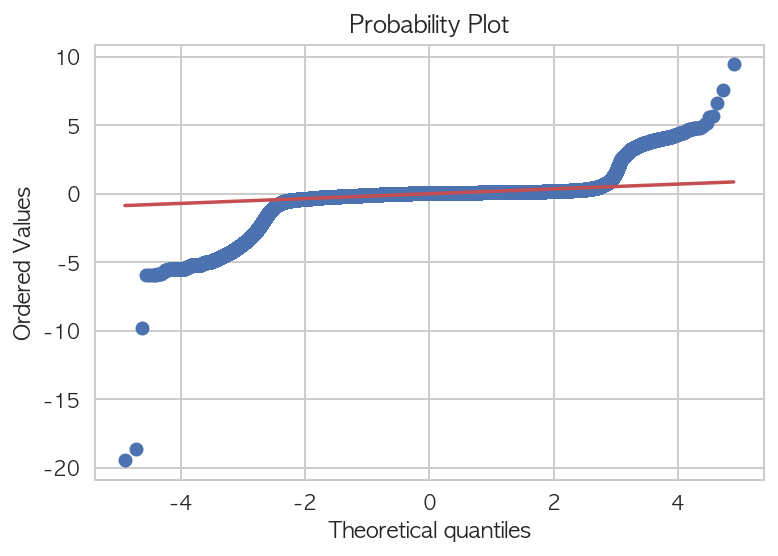

In [86]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [ ]:
log1p(trip_duration) ~ log1p(distance) + abs(np.sin(pickup_hour)) + 0